# Imaging Supernova

In this notebook, we will image a supernova with a low redshift. To fetch data, we will use the CADC package of astroquery, which queries data provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ).

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)

## 1. Introduction

The Scolnic et al. Supernova Catalog is one of the data products of the [Pan-STARRS Supernova (PS1 SN) Cosmology](https://archive.stsci.edu/prepds/ps1cosmo/) data release, it contains a list of supernova and their parameters. This tutorial will query this catalog for supernova with a low redshift. After selecting a supernova target, we query the CADC database for the target, then display some images.


## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:

```
# If you have a github account:
git clone git@github.com:astropy/astroquery.git
# If you do not:
git clone https://github.com/astropy/astroquery.git
cd astroquery
python setup.py install
```
Note that these commands can also be done in a jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`.
More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery).

Now, onto the tutorial. The first step is to import the CADC module from astroquery.

In [1]:
from astroquery.cadc import Cadc

cadc = Cadc()

## 3. Querying

### Find suitable target
For this tutorial, we want to look at low redshift supernova in the D2 field. To find a suitable supernova, we can look at the [Scolnic et al. Supernova Catalog](https://archive.stsci.edu/prepds/ps1cosmo/scolnic_datatable.html) where `Target ID` contains `D2` and `ZCMB` is `< 0.3`.

This gives 2 results: [05D2ah](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls05D2ah&submit=SIMBAD+search) and [06D2fb](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls06D2fb&submit=SIMBAD+search). Let's choose `05D2ah` to image.

Now we can query CADC database for objects that contain the `05D2ah` object as a target. After querying, we can filter down the results such that we only get objects of type `image` with energy in the range of $3000 \unicode[serif]{xC5}$ to $10000 \unicode[serif]{xC5}$. 

### The `query_name` function
The simplest way to query data by target name is to use the `query_name` function. It takes a string and [returns all the results that contain the string in the `target name` field](https://github.com/astropy/astroquery/blob/master/astroquery/cadc/core.py#L205-L208). After querying, we can further filter down the results using boolean masks on the data. In order to filter the data, we need to see which columns are in the results, and also what data type they are, this can be achieved by printing the results column names using `print(results.colnames)` or using the `results.info()` function after the query finishes. In this case, we want results that have the `energy_bounds_lower` field greater than $3000 \unicode[serif]{xC5}$, `energy_bounds_upper` field less than $10000 \unicode[serif]{xC5}$ and `dataProductType` of type 'image'. Since the energy bounds fields are in unit $m$, we will make a function to convert angstroms to meters. Once we filter the results, we will display a subset of the columns (since there are so many!) using the astropy table `show_in_notebook` method. First, let's start with the query...

In [2]:
# Fetch the results that contain the object name as a target
#object_name = '06D2fb'
object_name = '05D2ah'
results = cadc.query_name(object_name)

# Note: To get a list of column names: print(results.colnames)
#       To get a list and description of column names: results.info()

# Construct the filter
def ang_to_m(ang):
    return ang * 1e-10


lower_bound_m = ang_to_m(3000)
upper_bound_m = ang_to_m(10000)

results_filter = (results['energy_bounds_lower'] >= lower_bound_m) &\
                 (results['energy_bounds_upper'] <= upper_bound_m) &\
                 (results['dataProductType'] == 'image')

# Apply the filter to the results
filtered_results = results[results_filter]

# Print results
print('Number of results pre-filter: {}'.format(len(results)))
print('Number of results: {}'.format(len(filtered_results)))

columns_subset = [
    'productID', 'collection', 'energy_bounds_lower', 'energy_bounds_upper',
    'calibrationLevel', 'target_name', 'dataProductType'
]

filtered_results[columns_subset].show_in_notebook()

Number of results pre-filter: 6
Number of results: 4


idx,productID,collection,energy_bounds_lower,energy_bounds_upper,calibrationLevel,target_name,dataProductType
,,,m,m,,,
0,GN-2004B-Q-16-82-004,GEMINI,4.940000000000001e-07,6.300000000000001e-07,1,05D2ah,image
1,GN-2004B-Q-16-82-002,GEMINI,4.940000000000001e-07,6.300000000000001e-07,1,05D2ah,image
2,GN-2004B-Q-16-82-001,GEMINI,4.940000000000001e-07,6.300000000000001e-07,1,05D2ah,image
3,GN-2004B-Q-16-82-003,GEMINI,4.940000000000001e-07,6.300000000000001e-07,1,05D2ah,image


## 4. Fetching Data
Now let's get access to the results, download them, and display them. We will use the `get_data_urls` function to actually access the data.

In [4]:
# Get links to the data
urls = cadc.get_data_urls(results)

print(urls)

['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0184.fits.gz?RUNID=hsjl7aj113fn09do', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0183.fits.gz?RUNID=zucavko3d68e33rs', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0185.fits.gz?RUNID=uznp5h6x4ux2js7m']


The stucture of the url's can be broken into a few parts. Take `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726` as an example...
- `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/`: This is the service url. The 'data/pub' ending accesses all public files. For files that require authorization, there will be a redirect to 'data/auth' which require authorization
- `GEMINI`: This is the archive name.
- `N20050108S0186.fits.gz`: This is the file name.
- `RUNID=tv7rbo39ibkh7726`: This is used for logging and connecting services under the hood.

The urls give access to the actual data, so now we can fetch the file, get data to calculate a cutout, open it with the astropy fits module, and display an image!

### Retriving Data with Astropy.io
With the urls, we can now download the data. Before downloading the urls though, we want to take a cutout so we only download the data we want to look at, rather than the whole fits file. There are many different methods to perform a cutout, but today we will add the cutout region string to the parameter in the request and use the `caom2ops/cutout` service. Looking at [05D2ah](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=snls05D2ah&submit=SIMBAD+search) data, we will use the ICRS coordinates of `10 01 28.728 +01 51 45.83` to do the cutout. More information about requesting CADC data can be found [in the documentation](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/).


In [6]:
import re
import urllib
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS


#NOTE: This will get replaced by a astroquery.cadc module function, so let it be ugly
def get_cutout_image_data_from_url(url, ra, dec, radius=0.01, ext=0, verbose=False):
    '''Returns the image data and wcs coordinate data of a fits file at the 
    given extension'''

    base_url = 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout'
    
    uri = 'ad:' + \
        re.findall(
            "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/(.+)\?RUNID=", url)[0]
    cutout_region_string = 'Circle ICRS {ra} {dec} {radius}'.format(
        ra=ra, dec=dec, radius=radius)
    params_dict = {'uri': uri, 'cutout': cutout_region_string}

    url_params = urllib.parse.urlencode(params_dict)
    data_url = '{}?{}'.format(base_url, url_params)
    try:
        with fits.open(data_url, ignore_missing_end=True) as hdulist:
            if verbose:
                hdulist.info()
            w = WCS(hdulist[ext].header)
            image_data = hdulist[ext].data
        return {'image_data': image_data, 'w': w}
    except:
        print('Error: Problem with {}'.format(data_url))
        return None


c = SkyCoord('10h01m28.728s', '+01d51m45.83s', frame='icrs', unit='deg')
coords = {'ra': c.ra.degree, 'dec': c.dec.degree, 'radius': 0.005}
data_list = [
    get_cutout_image_data_from_url(url,
                                   coords['ra'],
                                   coords['dec'],
                                   radius=coords['radius']) for url in urls
]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


## 5. Plotting Results

Now that we have all the image data, we can begin to plot the data!

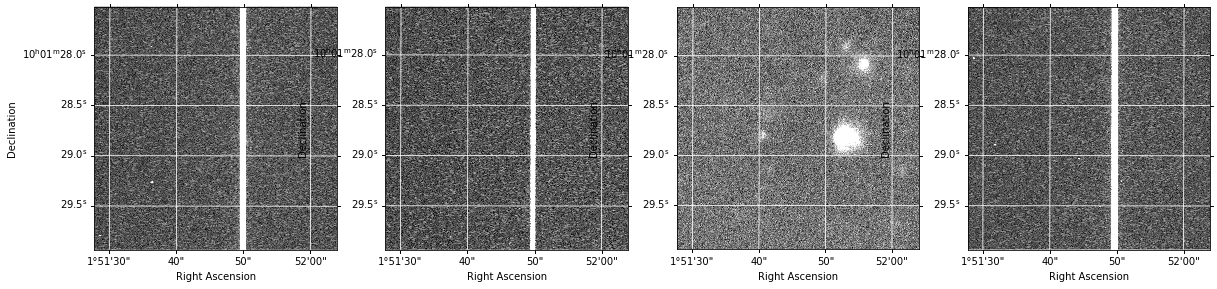

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import LinearStretch, ImageNormalize, ZScaleInterval

#TODO: Talk to Seb about plots, and why these are so ugly!
def plot_image_list(data_list, geo=None):

    if geo is None:
        geo = (1, len(data_list))  # nrows, ncols

    fig = plt.figure(figsize=(20, 10))
    for idx, data in enumerate(data_list):
        image_data, wcs = data['image_data'], data['w']
        ax = plt.subplot(geo[0], geo[1], idx + 1, projection=wcs)
        image_data_norm = ImageNormalize(image_data,
                                         interval=ZScaleInterval(),
                                         stretch=LinearStretch())
        ax.imshow(image_data, norm=image_data_norm, cmap='gray')
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_position('lb')
        dec.set_ticklabel_position('lb')
        ra.set_axislabel('Right Ascension')
        dec.set_axislabel('Declination')


plot_image_list(data_list)